Kaggle使用上传的d2l包

In [2]:
import sys
sys.path.append("../input/d2ld2l")
import d2l

一般来说，k个GPU并行训练过程如下:
* 在任何一次训练迭代中，给定的随机的小批量样本都将被分成k个部分，并均匀地分配到GPU上
* 每个GPU根据分配给它的小批量子集，计算模型参数的损失和梯度
* 将k个GPU中的局部梯度聚合，以获得当前小批量的随机梯度
* 聚合梯度被重新分发到每个GPU中
* 每个GPU使用这个小批量随机梯度，来更新它所维护的完整的模型参数集。</br>
在实践中请注意，当在k个GPU上训练时，需要扩大小批量的大小为k的倍数，这样每个GPU都有相同的工作量，就像只在单个GPU上训练一样。因此，在16-GPU服务器上可以显著地增加小批量数据量的大小，同时可能还需要相应地提高学习率。</br>
### 下面我们将使用一个简单网络来演示多GPU训练。


In [3]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

我们使用6.6节中介绍的（稍加修改的）LeNet， 从零开始定义它，从而详细说明参数交换和同步

In [4]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

### 数据同步
对于高效的多GPU训练，我们需要两个基本操作。</br>
* 首先，我们需要向多个设备分发参数并附加梯度（get_params）。 如果没有参数，就不可能在GPU上评估网络。 
* 第二，需要跨多个设备对参数求和，也就是说，需要一个allreduce函数。

In [5]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

通过将模型参数复制到一个GPU

In [6]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


由于还没有进行任何计算，因此权重参数的梯度仍然为零。</br>
假设现在有一个向量分布在多个GPU上，下面的allreduce函数将所有向量相加，并将结果广播给所有GPU。</br>
请注意，我们需要将数据复制到累积结果的设备，才能使函数正常工作。

In [7]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

通过在不同设备上创建具有不同值的向量并聚合它们

In [8]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


### 数据分发
我们需要一个简单的工具函数，将一个小批量数据均匀地分布在多个GPU上。</br>
例如，有两个GPU时，我们希望每个GPU可以复制一半的数据。因为深度学习框架的内置函数编写代码更方便、更简洁，所以在4×5矩阵上使用它进行尝试。


In [9]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


我们定义了可以同时拆分数据和标签的split_batch函数

In [10]:
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

# 训练
现在我们可以在一个小批量上实现多GPU训练。 在多个GPU之间同步数据将使用刚才讨论的辅助函数allreduce和split_and_load。 我们不需要编写任何特定的代码来实现并行性。 因为计算图在小批量内的设备之间没有任何依赖关系，因此它是“自动地”并行执行。

In [11]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

现在，我们可以定义训练函数。 与前几章中略有不同：训练函数需要分配GPU并将所有模型参数复制到所有设备。 显然，每个小批量都是使用train_batch函数来处理多个GPU。 我们只在一个GPU上计算模型的精确度，而让其他GPU保持空闲，尽管这是相对低效的，但是使用方便且代码简洁。

In [12]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

让我们看看在单个GPU上运行效果得有多好。 首先使用的批量大小是256，学习率是0.2

测试精度：0.79，7.3秒/轮，在[device(type='cuda', index=0)]


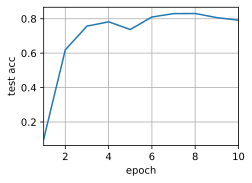

In [13]:
train(num_gpus=1, batch_size=256, lr=0.2)

In [14]:
#! pip install matplotlib==3.0.0 画图报错 重装后重启内核

保持批量大小和学习率不变，并增加为2个GPU，我们可以看到测试精度与之前的实验基本相同。 不同的GPU个数在算法寻优方面是相同的。 不幸的是，这里没有任何有意义的加速：模型实在太小了；而且数据集也太小了。在这个数据集中，我们实现的多GPU训练的简单方法受到了巨大的Python开销的影响。 在未来，我们将遇到更复杂的模型和更复杂的并行化方法。 尽管如此，让我们看看Fashion-MNIST数据集上会发生什么。

测试精度：0.83，7.3秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


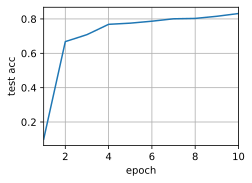

In [15]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 小结
* 有多种方法可以在多个GPU上拆分深度网络的训练。拆分可以在层之间、跨层或跨数据上实现。前两者需要对数据传输过程进行严格编排,而最后一种则是最简单的策略。
* 数据并行训练本身是不复杂的，它通过增加有效的小批量数据量的大小提高了训练效率。
* 在数据并行中，数据需要跨多个GPU拆分，其中每个GPU执行自己的前向传播和反向传播，随后所有的梯度被聚合为一，之后聚合结果向所有的GPU广播。
* 小批量数据量更大时，学习率也需要稍微提高一些。
